## Process the Label Array with WhisperSeg Vocalization Areas

In [1]:
import numpy as np

f = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/labels_for_training_classifier.npz"

# load the npz file
data = np.load(f)
# -1 will denote noise as well as silences and non-vocalizations etc
vocalization = data['vocalization']
labels = data['hdbscan_labels']
specs = data['original_spectogram']

# pad the first 20 spec dimensions with zeros, so that the dataclass doesnt need to be changed
specs = np.pad(specs, ((0, 0), (0, 20)), 'constant', constant_values=0)


# Goal is to create an array of labels, where the vocalized portions get the HDBSCAN labels, and non vocalized portions get a -1 label

# Create a copy of the vocalization array
temp = np.copy(vocalization)

# set all values to -1 
temp[:] = -1

indexes = np.where(vocalization == 1.0)[0]

for i, index in enumerate(indexes):
    temp[index] = labels[i]
labels = temp

# increase all labels by 1
labels += 1

num_classes = len(np.unique(labels))

# Save labels to a text file
# output_file = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/labels_output.txt"
# np.savetxt(output_file, labels, fmt='%d')

## Train Test Split

In [2]:
import os
import shutil

linear_decoder_test_dir = "/media/george-vengrovski/disk1/linear_decoder_test"
linear_decoder_train_dir = "/media/george-vengrovski/disk1/linear_decoder_train"

# if dir exists, delete all the data inside
if os.path.exists(linear_decoder_test_dir):
    shutil.rmtree(linear_decoder_test_dir)
os.makedirs(linear_decoder_test_dir)

if os.path.exists(linear_decoder_train_dir):
    shutil.rmtree(linear_decoder_train_dir)
os.makedirs(linear_decoder_train_dir)

length = 1000
test_train_split = 0.8

# temp storage before train test split 
list_of_data = []

# we need labels and specs saved to npz 
for i in range(0, len(labels), length):
    list_of_data.append((labels[i:i+length], specs[i:i+length], vocalization[i:i+length]))

# shuffle the list of data
np.random.shuffle(list_of_data)

# split the list of data into train and test
train_data = list_of_data[:int(len(list_of_data)*test_train_split)]
test_data = list_of_data[int(len(list_of_data)*test_train_split):]

# Print the shape of all data points in train and test data
print("Train Data Shapes:")
for i, data in enumerate(train_data):
    print(f"Data point {i}: labels shape {data[0].shape}, specs shape {data[1].T.shape}, vocalization shape {data[2].shape}")
    np.savez(linear_decoder_train_dir + "/" + str(i) + ".npz", labels=data[0], s=data[1].T, vocalization=data[2])

print("Test Data Shapes:")
for i, data in enumerate(test_data):
    print(f"Data point {i}: labels shape {data[0].shape}, specs shape {data[1].T.shape}, vocalization shape {data[2].shape}")
    np.savez(linear_decoder_test_dir + "/" + str(i) + ".npz", labels=data[0], s=data[1].T, vocalization=data[2])

Train Data Shapes:
Data point 0: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 1: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 2: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 3: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 4: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 5: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 6: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 7: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 8: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 9: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 10: labels shape (1000,), specs shape (216, 1000), vocalization shape (1000,)
Data point 1

## Train Linear Classifier

In [3]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import CollateFunction
from utils import load_model

weights_path = "experiments/padded_model_for_linear_decoder/saved_weights/model_step_15000.pth"
config_path = "experiments/padded_model_for_linear_decoder/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

linear_decoder_test_dir = "/media/george-vengrovski/disk1/linear_decoder_test"
linear_decoder_train_dir = "/media/george-vengrovski/disk1/linear_decoder_train"

train_dataset = SongDataSet_Image(linear_decoder_train_dir, num_classes=num_classes, infinite_loader=False)
test_dataset = SongDataSet_Image(linear_decoder_test_dir, num_classes=num_classes, infinite_loader=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=True, collate_fn=collate_fn)

In [5]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=num_classes, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=2, layer_id="attention_output", classifier_dims=196)
classifier_model = classifier_model.to(device)

Step 10: Train Loss 0.5855 FER = 15.67%, Val Loss = 0.7026
Step 20: Train Loss 0.2627 FER = 9.20%, Val Loss = 0.3252
Step 30: Train Loss 0.2071 FER = 8.24%, Val Loss = 0.2853
Step 40: Train Loss 0.1649 FER = 5.63%, Val Loss = 0.1779
Step 50: Train Loss 0.2313 FER = 6.81%, Val Loss = 0.1952
Step 60: Train Loss 0.1471 FER = 7.15%, Val Loss = 0.2075
Step 70: Train Loss 0.1483 FER = 6.48%, Val Loss = 0.1935
Step 80: Train Loss 0.1543 FER = 3.75%, Val Loss = 0.1052
Step 90: Train Loss 0.1253 FER = 5.59%, Val Loss = 0.1725
Step 100: Train Loss 0.1541 FER = 5.26%, Val Loss = 0.1535
Step 110: Train Loss 0.1683 FER = 4.35%, Val Loss = 0.1176
Step 120: Train Loss 0.1427 FER = 5.55%, Val Loss = 0.1616
Step 130: Train Loss 0.1348 FER = 5.32%, Val Loss = 0.1516
Step 140: Train Loss 0.1307 FER = 4.93%, Val Loss = 0.1405
Step 150: Train Loss 0.1305 FER = 4.25%, Val Loss = 0.1230
Early stopping triggered


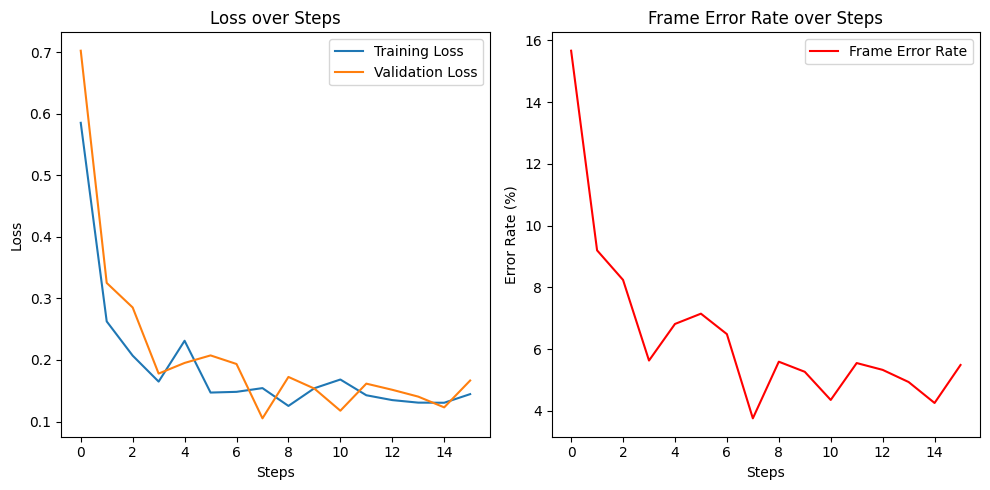

In [6]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-5, plotting=True, batches_per_eval=10, desired_total_batches=1e4, patience=8)
trainer.train()

In [9]:
from linear_probe import ModelEvaluator


# Initialize the ModelEvaluator with the filter_unseen_classes feature
evaluator = ModelEvaluator(model=classifier_model, 
                           test_loader=test_loader, 
                           num_classes=num_classes,  
                           device='cuda:0',  # Use CUDA if available
                           use_tqdm=True,  # Enable a progress bar for the evaluation
                           filter_unseen_classes=True,  # Enable filtering based on training set classes
                           train_dir=linear_decoder_train_dir)  # Path to the training dataset directory

# Perform model validation with multiple passes
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)

# Save the results to a specified directory, for example 'evaluation_results'
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, '')


Evaluating:   0%|          | 0/1250 [00:00<?, ?batch/s]

RuntimeError: shape '[-1, 1000, 196]' is invalid for input of size 57360000